# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
# dataDir = "D:/desktop_alternative/buetav/behavior-hypotheses-main/location-2"
# dataDir ="C:/Users/ASUS/Desktop/buetav/behavior-hypotheses-main/location-2"
# dataDir = "C:/Users/Zenbook325E/Downloads/csv"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [2]:
# exec(open('D:/desktop_alternative/buetav/behavior-hypotheses-main/src/notebooks/init_notebook.py').read())
exec(open('D:/desktop_alternative/buetav/src/notebooks/init_notebook.py').read())
# D:\desktop_alternative\buetav\src\notebooks

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
# sys.path.append(os.path.abspath('C:/Users/ASUS/Desktop/buetav/behavior-hypotheses-main/src'))
sys.path.append(os.path.abspath('D:/desktop_alternative/buetav/src'))
from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
# import behavior_tools
from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

from behavior_tools.AngularDisplacementCalculator import AngularDisplacementCalculator

In [5]:
dataDir = "D:/desktop_alternative/buetav/location-2"
# dataDir = "D:/desktop_alternative/buetav/behavior-hypotheses-main/location-2"

sceneId = 210
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [6]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        # xAccCol='sceneXAcceleration',
        # yAccCol='sceneYAcceleration',
        speedCol='speed',
        fps=10,
        # accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
      
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
# transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

In [7]:
xCol="sceneX"
yCol="sceneY"
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate180(trackDf,xCol,yCol)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


11101

### Right side of the vertical axis is negative

In [8]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
startingDf.head(10)
# startingDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,-0.629400,-2.454854
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,-0.637141,-2.358691
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,-0.644921,-2.261374
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,-0.653314,-2.163065
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,-0.661952,-2.065082
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,-0.670135,-1.967831
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,-0.679707,-1.870670
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,-0.690215,-1.773153
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,-0.701232,-1.674626
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,-0.712428,-1.575365


In [9]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

# print(allPedIds)
# allPedIdAverageAngularDisplacement=0
# allPedIdMaxAngularDisplacement=0
# allPedIdAngularDisplacementSum=0 
# uniqueIdAngularDisplacement=0
tableofAllPedIdMaxAndAverageAngularDisplacementPerSecond=[]
maxPedId=0
minPedId=1e6
testCount=0

for pedId in allPedIds:
    if(pedId>3e5):
        testCount+=1
        continue
    maxPedId=max(maxPedId,pedId)
    minPedId=min(minPedId,pedId)
    uniqueIdAverageAngularDisplacementPerSecond=0
    uniqueIdMaxAngularDisplacementPerSecond=0
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackDf = AngularDisplacementCalculator.addAngularDisplacement(trackDf)
    trackDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(trackDf)
    absoluteAngularDisplacementPerSecondTable = AngularDisplacementCalculator.getAbsoluteAngularDisplacementTable(trackDf)
    for value in absoluteAngularDisplacementPerSecondTable:
        uniqueIdAverageAngularDisplacementPerSecond+=value[1]
        uniqueIdMaxAngularDisplacementPerSecond=max(uniqueIdMaxAngularDisplacementPerSecond,value[1])
    uniqueIdAverageAngularDisplacementPerSecond/=len(absoluteAngularDisplacementPerSecondTable)
    tableofAllPedIdMaxAndAverageAngularDisplacementPerSecond.append((pedId,uniqueIdMaxAngularDisplacementPerSecond,uniqueIdAverageAngularDisplacementPerSecond))


print(testCount)
print(minPedId)
print(maxPedId)


1
18023
29542


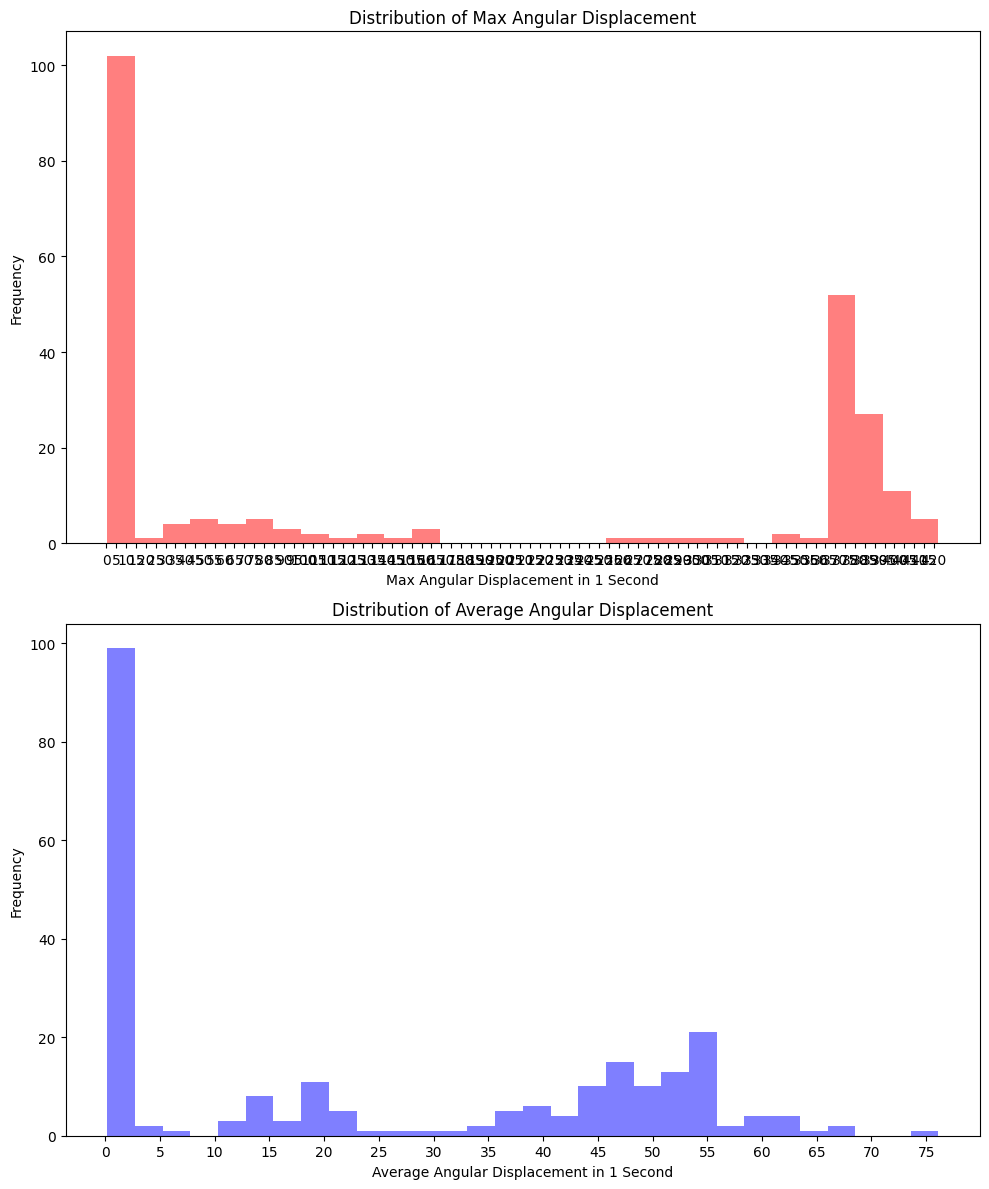

In [10]:
import matplotlib.pyplot as plt

# Define the specific range for the X-axis
minPedId = 18023
maxPedId = 29542

# Extract data from the table
pedIds = [item[0] for item in tableofAllPedIdMaxAndAverageAngularDisplacementPerSecond]
maxAngularDisplacements = [item[1] for item in tableofAllPedIdMaxAndAverageAngularDisplacementPerSecond]
averageAngularDisplacements = [item[2] for item in tableofAllPedIdMaxAndAverageAngularDisplacementPerSecond]

# Create the plot with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot histogram for max angular displacement
ax1.hist(maxAngularDisplacements, bins=30, color='red', alpha=0.5)
ax1.set_xlabel('Max Angular Displacement in 1 Second')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Max Angular Displacement')

# Set X-axis ticks for max angular displacement
ax1.set_xticks(range(int(min(maxAngularDisplacements)), int(max(maxAngularDisplacements)) + 1, 5))

# Plot histogram for average angular displacement
ax2.hist(averageAngularDisplacements, bins=30, color='blue', alpha=0.5)
ax2.set_xlabel('Average Angular Displacement in 1 Second')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Average Angular Displacement')

# Set X-axis ticks for average angular displacement
ax2.set_xticks(range(int(min(averageAngularDisplacements)), int(max(averageAngularDisplacements)) + 1, 5))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

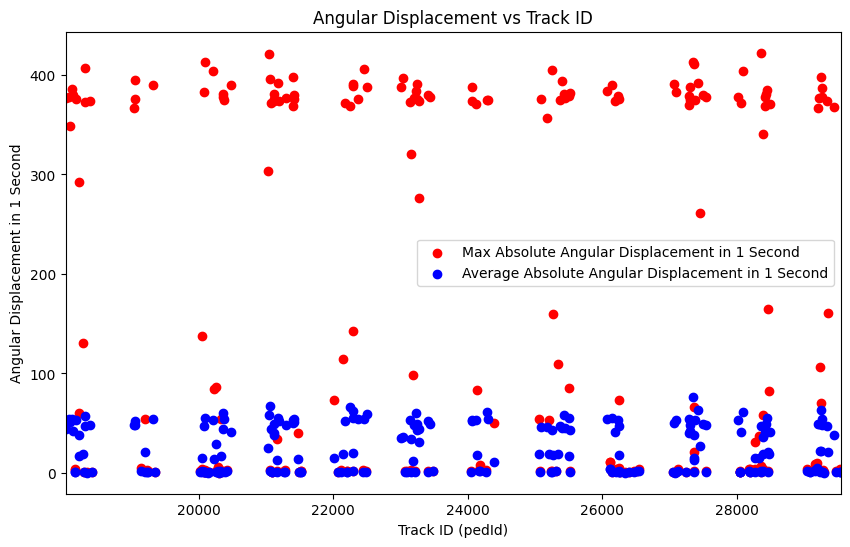

In [11]:


import matplotlib.pyplot as plt

# Define the specific range for the X-axis
minPedId = 18023
maxPedId = 29542

# Extract data from the table
pedIds = [item[0] for item in tableofAllPedIdMaxAndAverageAngularDisplacementPerSecond]
maxAngularDisplacements = [item[1] for item in tableofAllPedIdMaxAndAverageAngularDisplacementPerSecond]
averageAngularDisplacements = [item[2] for item in tableofAllPedIdMaxAndAverageAngularDisplacementPerSecond]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot max angular displacement
plt.scatter(pedIds, maxAngularDisplacements, color='red', label='Max Absolute Angular Displacement in 1 Second')

# Plot average angular displacement
plt.scatter(pedIds, averageAngularDisplacements, color='blue', label='Average Absolute Angular Displacement in 1 Second')

# Set X-axis range
plt.xlim(minPedId, maxPedId)

# Format the X-axis to avoid scientific notation
plt.ticklabel_format(style='plain', axis='x')

# Add labels and title
plt.xlabel('Track ID (pedId)')
plt.ylabel('Angular Displacement in 1 Second')
plt.title('Angular Displacement vs Track ID')
plt.legend()

# Show the plot
plt.show()

In [12]:
#  Angular Displacement')

# # Set X-axis range
# plt.xlim(minPedId, maxPedId)

# # Format the X-axis to avoid scientific notation
# plt.ticklabel_format(style='plain', axis='x')

# # Add labels and title
# plt.xlabel('Track ID (pedId)')
# plt.ylabel('Angular Displacement')
# plt.title('Angular Displacement vs Track ID')
# plt.legend()

# # Show the plot
# plt.show()

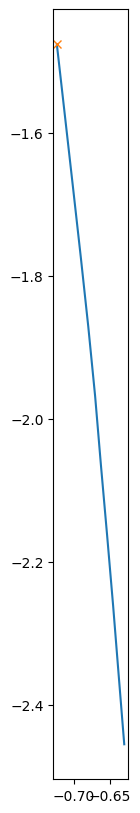

In [13]:
starting023 = startingDf[startingDf["uniqueTrackId"] == 18023].copy()
visualizer.show(starting023, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
# starting023.size
# starting023

# starting023= startingDf

In [14]:
starting023 = AngularDisplacementCalculator.addAngularDisplacement(starting023)
starting023 = AngularDisplacementCalculator.addRelativeAngularDisplacement(starting023)
starting023

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY,angularDisplacement,relativeAngularDisplacement,absoluteAngularDisplacement
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,-0.629400,-2.454854,0.000000,0.000000,0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,-0.637141,-2.358691,-195.116255,0.000000,0.000000
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,-0.644921,-2.261374,-195.917608,-0.801353,0.801353
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,-0.653314,-2.163065,-196.805989,-0.888382,0.888382
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,-0.661952,-2.065082,-197.773015,-0.967026,0.967026
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,-0.670135,-1.967831,-198.806010,-1.032995,1.032995
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,-0.679707,-1.870670,-199.968590,-1.162580,1.162580
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,-0.690215,-1.773153,-201.268912,-1.300322,1.300322
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,-0.701232,-1.674626,-202.720988,-1.452077,1.452077
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,-0.712428,-1.575365,-204.333938,-1.612950,1.612950


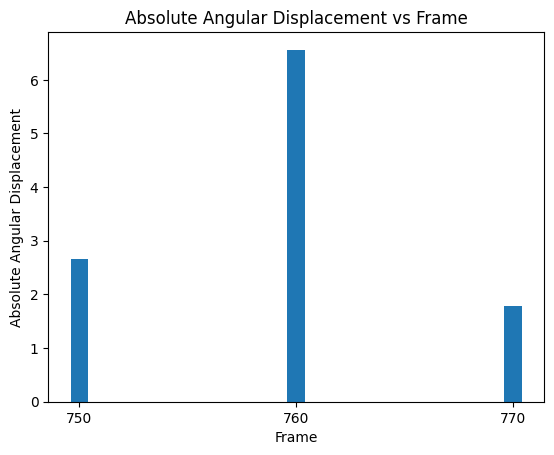

In [15]:
############################################
############################################
# Accessing the value
absoluteAngularDisplacementPerSecondTable = AngularDisplacementCalculator.getAbsoluteAngularDisplacementTable(starting023)
absoluteAngularDisplacementPerSecondTable

data = absoluteAngularDisplacementPerSecondTable  # or absoluteAngularDisplacementPerSecondTable['column_name'] if it's a DataFrame

# Convert the list of tuples to a DataFrame
absoluteAngularDisplacementPerSecondTable = pd.DataFrame(absoluteAngularDisplacementPerSecondTable, columns=["frame", "absoluteAngularDisplacement"])

# Plotting the bar chart
plt.bar(absoluteAngularDisplacementPerSecondTable["frame"], absoluteAngularDisplacementPerSecondTable["absoluteAngularDisplacement"])
plt.title('Absolute Angular Displacement vs Frame')
plt.xlabel('Frame')
plt.ylabel('Absolute Angular Displacement')

# Set x-ticks to the exact frame values in the table
plt.xticks(absoluteAngularDisplacementPerSecondTable["frame"])

plt.show()

    
# show_histogram(newAngularDisplacementDf, "maxRelativeAngularDisplacement", "Maximum Angular Displacement (degrees)")
# show_histogram(newAngularDisplacementDf, "meanAbsoluteRelativeAngularDisplacement", "Mean Angular Displacement (degrees)")

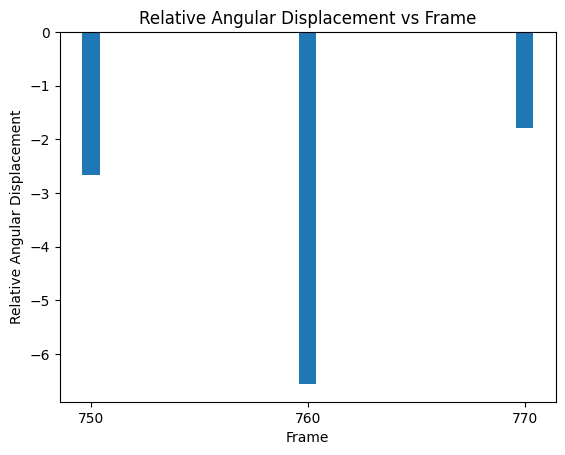

In [16]:
relativeAngularDisplacementTable = AngularDisplacementCalculator.getRelativeAngularDisplacementTable(starting023)
relativeAngularDisplacementTable

# Convert the list of tuples to a DataFrame
relativeAngularDisplacementTable = pd.DataFrame(relativeAngularDisplacementTable, columns=["frame", "relativeAngularDisplacement"])

# Take the absolute value of the relative angular displacement
relativeAngularDisplacementTable["relativeAngularDisplacement"] = relativeAngularDisplacementTable["relativeAngularDisplacement"]
#.abs()

# Plotting the bar chart
plt.bar(relativeAngularDisplacementTable["frame"], relativeAngularDisplacementTable["relativeAngularDisplacement"])
plt.title('Relative Angular Displacement vs Frame')
plt.xlabel('Frame')
plt.ylabel('Relative Angular Displacement')

# Set x-ticks to the exact frame values in the table
plt.xticks(relativeAngularDisplacementTable["frame"])

plt.show()

In [17]:
newAngularDisplacementDf = AngularDisplacementCalculator.getPedAngularDisplacementDf(startingDf)
newAngularDisplacementDf

,uniqueTrackId,count,maxAngularDisplacement,meanAbsoluteAngularDisplacement,meanAngularDisplacement,maxRelativeAngularDisplacement,meanAbsoluteRelativeAngularDisplacement,meanRelativeAngularDisplacement,maxSpeed,meanSpeed
0,18023,11,206.116723,181.711639,-181.711639,1.782785,1.000043,-1.000043,0.499737,0.490995
1,18069,9,205.971667,176.645603,-176.645603,2.466731,1.470376,-1.470376,0.648834,0.631765
2,18090,7,185.631997,158.898241,-158.898241,0.149465,0.079323,-0.079323,0.802478,0.786039
3,18121,9,192.901086,167.105485,-167.105485,1.648615,1.009207,-1.009207,0.618203,0.609641
4,18134,11,214.239563,188.996919,-188.996919,1.787665,1.008142,-1.008142,0.479898,0.465436
...,...,...,...,...,...,...,...,...,...,...
232,29446,11,230.376192,204.462980,-204.462980,1.499054,0.926247,-0.926247,0.488508,0.464422
233,29467,10,20.116793,17.768814,17.768814,0.175623,0.077150,0.077150,0.586158,0.560428
234,29532,12,22.148625,20.160966,20.160966,0.054427,0.020154,-0.016322,0.480260,0.473395
235,29533,10,12.028110,10.425354,10.425354,0.464476,0.198838,0.040439,0.521367,0.505813


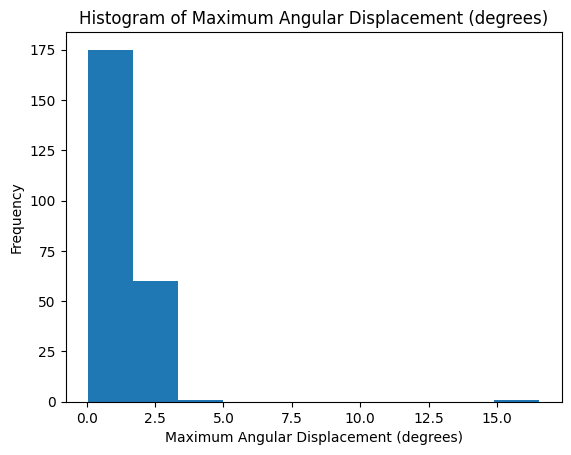

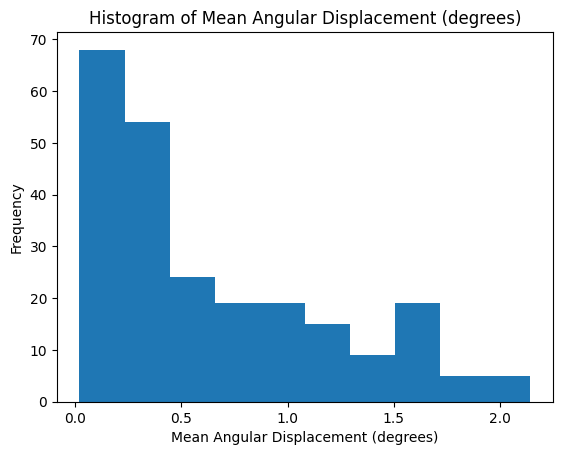

In [18]:
def show_histogram(df, column_name, axis_label):
    plt.hist(df[column_name])
    plt.xlabel(axis_label)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {axis_label}")
    plt.show()
    
show_histogram(newAngularDisplacementDf, "maxRelativeAngularDisplacement", "Maximum Angular Displacement (degrees)")
show_histogram(newAngularDisplacementDf, "meanAbsoluteRelativeAngularDisplacement", "Mean Angular Displacement (degrees)")


<AxesSubplot: xlabel='meanRelativeAngularDisplacement', ylabel='maxRelativeAngularDisplacement'>

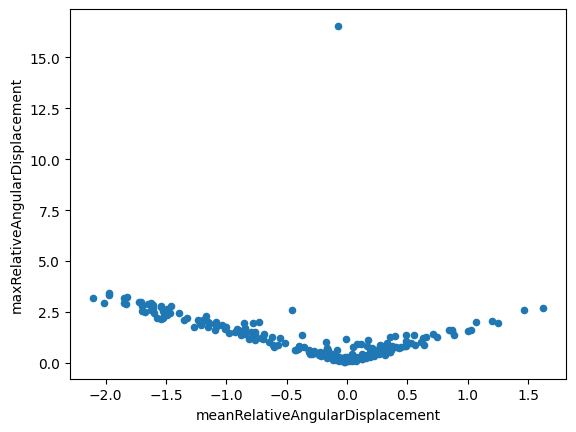

In [19]:
# ommit the first two columns
# plot between meanRelativeAngularDisplacement and maxRelativeAngularDisplacement
newAngularDisplacementDf.iloc[:, 2:].plot(kind='scatter', x='meanRelativeAngularDisplacement', y='maxRelativeAngularDisplacement')